In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from tqdm import tqdm
import sys
import warnings
warnings.filterwarnings("ignore")

# Reading the Data

In [2]:
data = pd.read_csv('in-vehicle-coupon-recommendation.csv')
data.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [3]:
print("Number of data points:", data.shape[0])
print("Number of features:", data.shape[1])
print('-'*100)
print("The attributes of data :", data.columns.values)

Number of data points: 12684
Number of features: 26
----------------------------------------------------------------------------------------------------
The attributes of data : ['destination' 'passanger' 'weather' 'temperature' 'time' 'coupon'
 'expiration' 'gender' 'age' 'maritalStatus' 'has_children' 'education'
 'occupation' 'income' 'car' 'Bar' 'CoffeeHouse' 'CarryAway'
 'RestaurantLessThan20' 'Restaurant20To50' 'toCoupon_GEQ5min'
 'toCoupon_GEQ15min' 'toCoupon_GEQ25min' 'direction_same' 'direction_opp'
 'Y']


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

# Data Cleaning

In [5]:
# Remove duplicates
duplicate = data[data.duplicated(keep = 'last')]
# duplicate.shape #(74, 26)
data = data.drop_duplicates()
print(data.shape)

(12610, 26)


In [6]:
# missing values
print('Is there any missing value present or not?',data.isnull().values.any())
missing_percentage = data.isnull().sum()*100/len(data)
missing_value_df = pd.DataFrame({'missing_count': data.isnull().sum(),'missing_percentage': missing_percentage})
missing_value_df[missing_value_df.missing_count != 0]

Is there any missing value present or not? True


,missing_count,missing_percentage
car,12502,99.143537
Bar,107,0.848533
CoffeeHouse,217,1.720856
CarryAway,150,1.189532
RestaurantLessThan20,129,1.022998
Restaurant20To50,189,1.498810


 - Feature 'car' has 99% of the missing value, drop this feature because even after predicting missing values, this feature has less importance, and it has less predictive power.

In [7]:
data = data.drop(['car'], axis=1)

In [8]:
# mode imputation for missing values
data['Bar'] = data['Bar'].fillna(data['Bar'].value_counts().index[0])
data['CoffeeHouse'] = data['CoffeeHouse'].fillna(data['CoffeeHouse'].value_counts().index[0])
data['CarryAway'] = data['CarryAway'].fillna(data['CarryAway'].value_counts().index[0])
data['RestaurantLessThan20'] = data['RestaurantLessThan20'].fillna(data['RestaurantLessThan20'].value_counts().index[0])
data['Restaurant20To50'] = data['Restaurant20To50'].fillna(data['Restaurant20To50'].value_counts().index[0])

In [9]:
print('Is there any missing value present or not?',data.isnull().values.any())

Is there any missing value present or not? False


### Correlation Features

In [10]:
data.cov() # Co-variance matrix

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
temperature,366.852199,-0.175502,0.0,-1.493656,-1.393448,0.771641,-0.771641,0.563590
has_children,-0.175502,0.242711,0.0,0.019427,-0.001700,-0.006554,0.006554,-0.010997
toCoupon_GEQ5min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
toCoupon_GEQ15min,-1.493656,0.019427,0.0,0.246444,0.051076,-0.061664,0.061664,-0.020338
toCoupon_GEQ25min,-1.393448,-0.001700,0.0,0.051076,0.102567,-0.025009,0.025009,-0.017158
direction_same,0.771641,-0.006554,0.0,-0.061664,-0.025009,0.169098,-0.169098,0.003042
direction_opp,-0.771641,0.006554,0.0,0.061664,0.025009,-0.169098,0.169098,-0.003042
Y,0.563590,-0.010997,0.0,-0.020338,-0.017158,0.003042,-0.003042,0.245454


1.Feature ‘direction_same’ is perfectly correlated with ‘direction_opp’, both have the same variance.

2.‘toCoupon_GEQ5min’ feature has no correlation with any feature because it has the same value ‘1’ for all data points, which means all the restaurants/bars are at least more than five minutes away from the driver.

So, drop both 'direction_opp' and 'toCoupon_GEQ5min' features.

In [11]:
data = data.drop(['direction_opp', 'toCoupon_GEQ5min'], axis=1)
data.shape

(12610, 23)

# FeatureEngineering

In [12]:
# FE -- to_Coupon is combination of two feature, toCoupon_GEQ15min and toCoupon_GEQ25min
to_Coupon = []
for i in tqdm(range(data.shape[0])):
    if (list(data['toCoupon_GEQ15min'])[i] == 0):
        to_Coupon.append(0)
    elif (list(data['toCoupon_GEQ15min'])[i] == 1)and(list(data['toCoupon_GEQ25min'])[i] == 0):
        to_Coupon.append(1)
    else:
        to_Coupon.append(2)
        
# print(len(to_Coupon)) #12610
data['to_Coupon'] = to_Coupon

100%|██████████| 12610/12610 [00:43<00:00, 287.19it/s]


# Data Analysis

In [13]:
print("After data cleaning and Feature Engineering,")
print("Number of data points:", data.shape[0])
print("Number of features:", data.shape[1])
print('-'*100)
print("The attributes of data :\n", data.columns.values)

After data cleaning and Feature Engineering,
Number of data points: 12610
Number of features: 24
----------------------------------------------------------------------------------------------------
The attributes of data :
 ['destination' 'passanger' 'weather' 'temperature' 'time' 'coupon'
 'expiration' 'gender' 'age' 'maritalStatus' 'has_children' 'education'
 'occupation' 'income' 'Bar' 'CoffeeHouse' 'CarryAway'
 'RestaurantLessThan20' 'Restaurant20To50' 'toCoupon_GEQ15min'
 'toCoupon_GEQ25min' 'direction_same' 'Y' 'to_Coupon']


In [14]:
data.describe()

,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y,to_Coupon
count,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000
mean,63.267248,0.414512,0.559794,0.116019,0.215543,0.567565,0.675813
std,19.153386,0.492657,0.496432,0.320260,0.411215,0.495434,0.671687
min,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,80.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [15]:
Y_value_counts = data.groupby('Y').Y.count()
print('The number of users that are accepted the coupon is ',Y_value_counts[1],',',round(Y_value_counts[1]/data.shape[0]*100,3),'%')
print('The number of users that are rejected the coupon is ',Y_value_counts[0],',',round(Y_value_counts[0]/data.shape[0]*100,3),'%')

The number of users that are accepted the coupon is  7157 , 56.757 %
The number of users that are rejected the coupon is  5453 , 43.243 %


### Univariate Analysis

In [16]:
def univariate_analysis(column_name):
    df_EDA = pd.DataFrame(sorted(list(data[column_name].unique())),columns=[column_name])
    df_EDA['Total_Count'] = list(data.groupby(column_name).Y.count())
    df_EDA['Accepted'] = list(data[data.Y==1].groupby(column_name).Y.count())
    df_EDA['Rejected'] = list(data[data.Y==0].groupby(column_name).Y.count())
    df_EDA['%Accepted'] = round(df_EDA['Accepted']/df_EDA['Total_Count']*100,3)
    df_EDA['%Rejected'] = round(df_EDA['Rejected']/df_EDA['Total_Count']*100,3)
    df_EDA = df_EDA.sort_values(by='Total_Count', ascending=False)
    
    fig = plt.subplots(figsize =(8, 4))
    plt.barh(df_EDA[column_name],df_EDA['Total_Count'])
    plt.barh(df_EDA[column_name],df_EDA['Accepted'])
    plt.legend(labels=['Total','Accepted'])
    plt.xlabel('Counts')
    plt.title(column_name+' wise accepted coupons')
    plt.show()

    return df_EDA

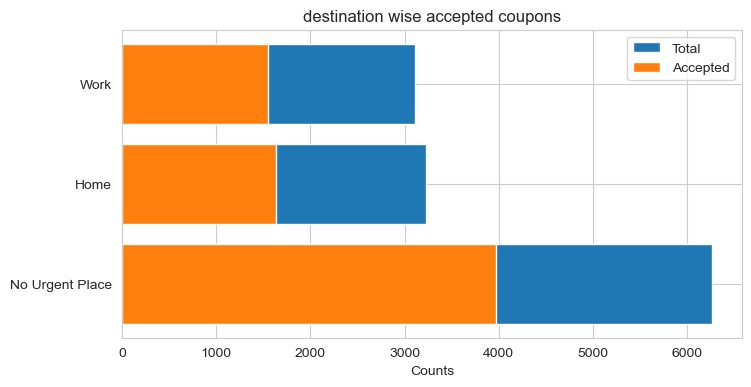

,destination,Total_Count,Accepted,Rejected,%Accepted,%Rejected
1,No Urgent Place,6266,3969,2297,63.342,36.658
0,Home,3230,1635,1595,50.619,49.381
2,Work,3114,1553,1561,49.872,50.128


In [17]:
univariate_analysis('destination')

#### Observations:

   - Most of the users go to No Urgent Place
   - The users who have destination No Urgent Place are accepting more coupons      than others.
   - The users who have destination Home and Work have almost similar coupon        acceptance ratios.

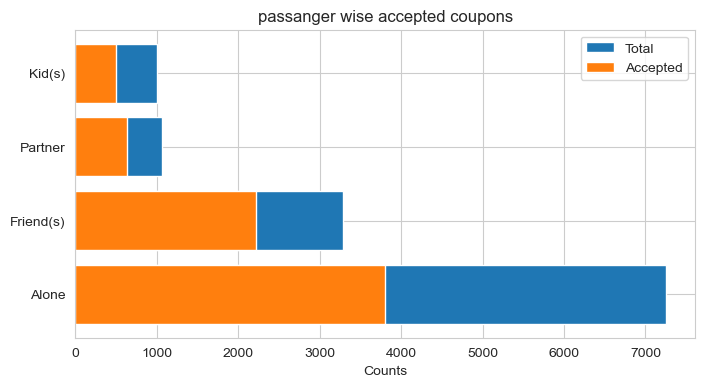

,passanger,Total_Count,Accepted,Rejected,%Accepted,%Rejected
0,Alone,7248,3801,3447,52.442,47.558
1,Friend(s),3292,2216,1076,67.315,32.685
3,Partner,1069,635,434,59.401,40.599
2,Kid(s),1001,505,496,50.450,49.550


In [18]:
univariate_analysis('passanger')

#### Observations:

  - Most of the time users go out Alone.
  - The users who go out with Friends are accepting more coupons than other co-     passengers.
  - The users who go out with Friends or Partner have more coupon acceptance       ratios than Alone users.

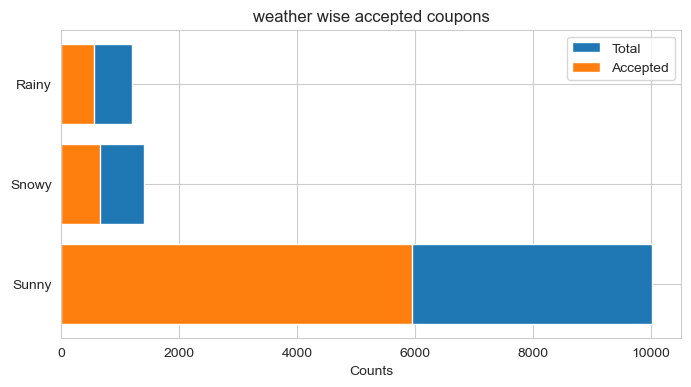

,weather,Total_Count,Accepted,Rejected,%Accepted,%Rejected
2,Sunny,10011,5941,4070,59.345,40.655
1,Snowy,1397,659,738,47.173,52.827
0,Rainy,1202,557,645,46.339,53.661


In [19]:
univariate_analysis('weather')

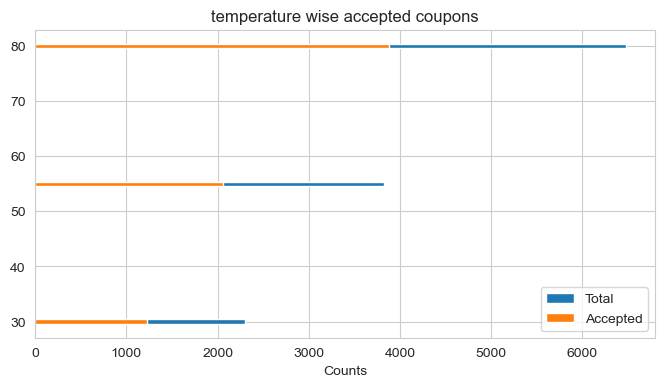

,temperature,Total_Count,Accepted,Rejected,%Accepted,%Rejected
2,80,6475,3876,2599,59.861,40.139
1,55,3830,2056,1774,53.681,46.319
0,30,2305,1225,1080,53.145,46.855


In [20]:
univariate_analysis('temperature')

#### Observations:

   - Most of the time users go out when the temperature is 80 F.
   - When the temperature is 80 F, user's coupon acceptance ratio is approx          59.86%.

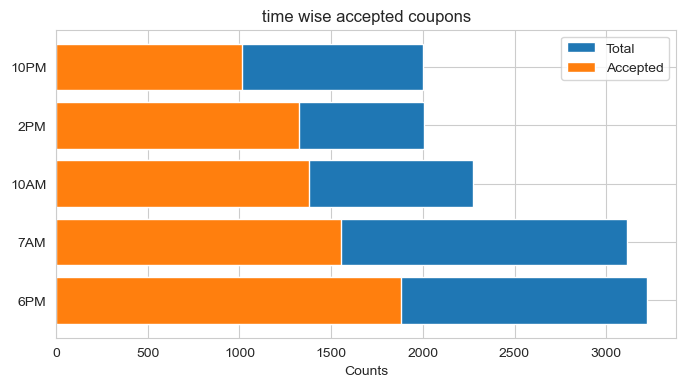

,time,Total_Count,Accepted,Rejected,%Accepted,%Rejected
3,6PM,3220,1881,1339,58.416,41.584
4,7AM,3114,1553,1561,49.872,50.128
0,10AM,2271,1380,891,60.766,39.234
2,2PM,2006,1327,679,66.152,33.848
1,10PM,1999,1016,983,50.825,49.175


In [21]:
univariate_analysis('time')

#### Observations:

   - Most of the time users go out when the time is 6 PM and 7 AM.
   - The users mostly accept coupons when the time is 2 PM and 10 AM.

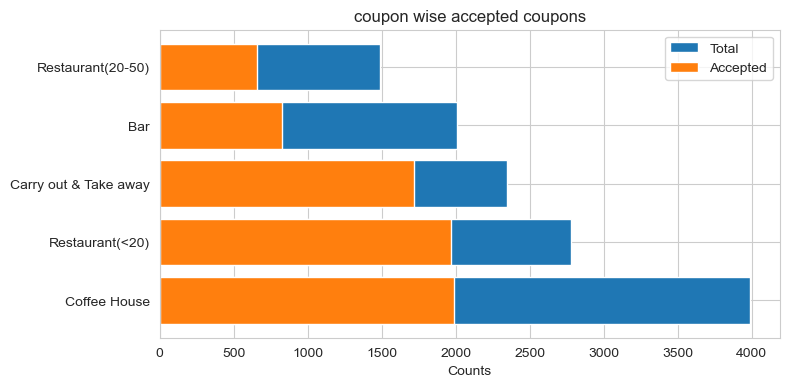

,coupon,Total_Count,Accepted,Rejected,%Accepted,%Rejected
2,Coffee House,3989,1989,2000,49.862,50.138
4,Restaurant(<20),2779,1967,812,70.781,29.219
1,Carry out & Take away,2344,1720,624,73.379,26.621
0,Bar,2010,824,1186,40.995,59.005
3,Restaurant(20-50),1488,657,831,44.153,55.847


In [22]:
univariate_analysis('coupon')

#### Observations:

  - Maximum coupons offered are for Coffee House coupons.
  - Maximum coupons accepted by users are Carry out & Take away and                 Restaurant(<20) coupons.
  - Bar coupon has a very low acceptance ratio.

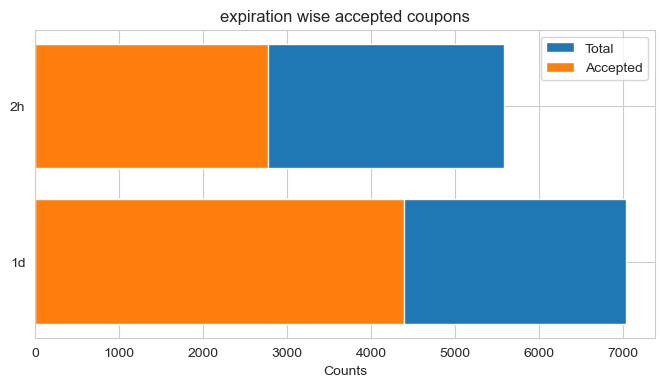

,expiration,Total_Count,Accepted,Rejected,%Accepted,%Rejected
0,1d,7031,4390,2641,62.438,37.562
1,2h,5579,2767,2812,49.597,50.403


In [23]:
univariate_analysis('expiration')

#### Observations:

   - Maximum coupons are one-day expiration coupons
   - Most of the users accept one-day expiration coupons.
   - Two hours expiration coupons have a 50% acceptance ratio.

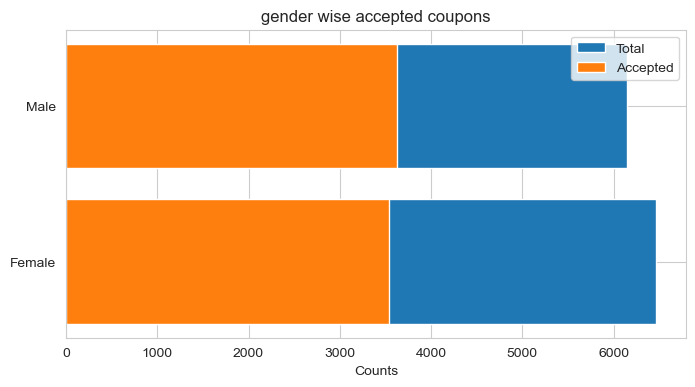

,gender,Total_Count,Accepted,Rejected,%Accepted,%Rejected
0,Female,6469,3535,2934,54.645,45.355
1,Male,6141,3622,2519,58.981,41.019


In [24]:
univariate_analysis('gender')

#### Observations:

   - Male and Female both have almost similar coupon acceptance ratios.

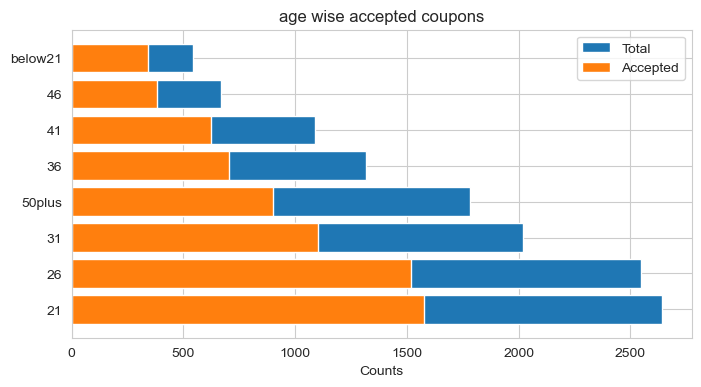

,age,Total_Count,Accepted,Rejected,%Accepted,%Rejected
0,21,2642,1579,1063,59.765,40.235
1,26,2548,1517,1031,59.537,40.463
2,31,2019,1102,917,54.581,45.419
6,50plus,1781,903,878,50.702,49.298
3,36,1317,705,612,53.531,46.469
4,41,1089,623,466,57.208,42.792
5,46,670,384,286,57.313,42.687
7,below21,544,344,200,63.235,36.765


In [25]:
univariate_analysis('age')

#### Observations:

   - Most users in this data have ages between 21 to 26 years.
   - The users whose age is below 21 years have the highest coupon acceptance        ratio.
   - The users whose age is above 50 years have the highest coupon rejection        ratio.

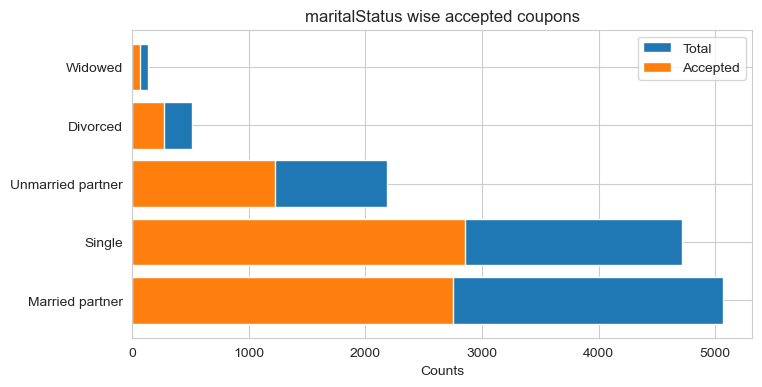

,maritalStatus,Total_Count,Accepted,Rejected,%Accepted,%Rejected
1,Married partner,5068,2749,2319,54.242,45.758
2,Single,4716,2851,1865,60.454,39.546
3,Unmarried partner,2185,1226,959,56.110,43.890
0,Divorced,511,269,242,52.642,47.358
4,Widowed,130,62,68,47.692,52.308


In [26]:
univariate_analysis('maritalStatus')

#### Observations:

  - Most users in this data are Single or have Married partner.
  - Single users accept more coupons than others.
  - Users who have Unmarried partner accept more coupons than Married partner       users.

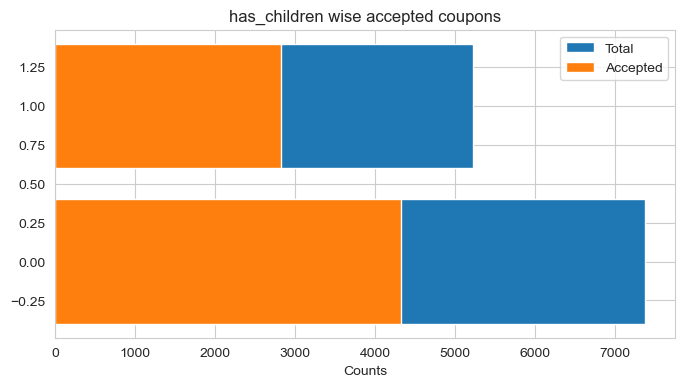

,has_children,Total_Count,Accepted,Rejected,%Accepted,%Rejected
0,0,7383,4329,3054,58.635,41.365
1,1,5227,2828,2399,54.104,45.896


In [27]:
univariate_analysis('has_children')

#### Observations:

  - Most users has no children.
  - Users who have no children have a slightly higher acceptance ratio than the     users who have children.

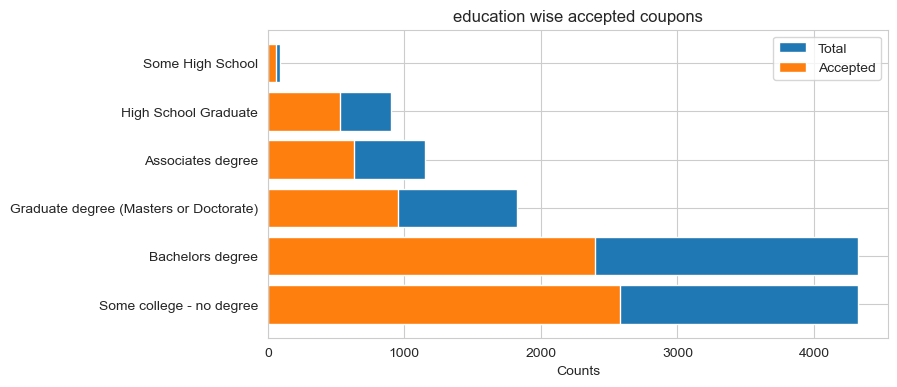

,education,Total_Count,Accepted,Rejected,%Accepted,%Rejected
5,Some college - no degree,4325,2577,1748,59.584,40.416
1,Bachelors degree,4323,2395,1928,55.401,44.599
2,Graduate degree (Masters or Doctorate),1827,956,871,52.326,47.674
0,Associates degree,1148,634,514,55.226,44.774
3,High School Graduate,899,532,367,59.177,40.823
4,Some High School,88,63,25,71.591,28.409


In [28]:
univariate_analysis('education')

#### Observations:

  - Most users have at least a Bachelor's degree or Some college - no degree.
  - In this data, very few users have only Some High School education, and         those users have the highest coupon acceptance ratio.
  - Users who have a Graduate degree (Masters or Doctorate) have the least         coupon acceptance ratio.

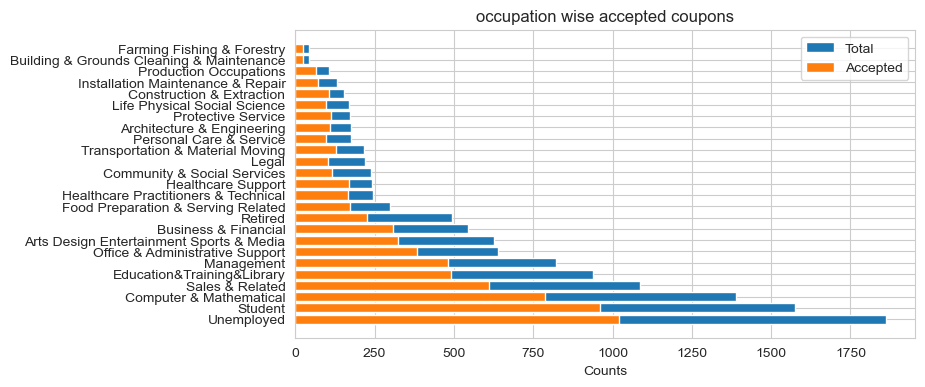

,occupation,Total_Count,Accepted,Rejected,%Accepted,%Rejected
24,Unemployed,1861,1019,842,54.756,45.244
22,Student,1575,960,615,60.952,39.048
5,Computer & Mathematical,1390,787,603,56.619,43.381
21,Sales & Related,1088,612,476,56.250,43.750
7,Education&Training&Library,939,490,449,52.183,47.817
15,Management,821,481,340,58.587,41.413
16,Office & Administrative Support,638,383,255,60.031,39.969
1,Arts Design Entertainment Sports & Media,627,324,303,51.675,48.325
3,Business & Financial,543,309,234,56.906,43.094
20,Retired,493,225,268,45.639,54.361


In [29]:
univariate_analysis('occupation')

#### Observations:

  - Most users in this data are Unemployed and Student.
  - Users who are students have more coupon acceptance ratio than Unemployed       users.
  - Users who have occupation Healthcare Support and Construction & Extraction     accept more coupons than others.

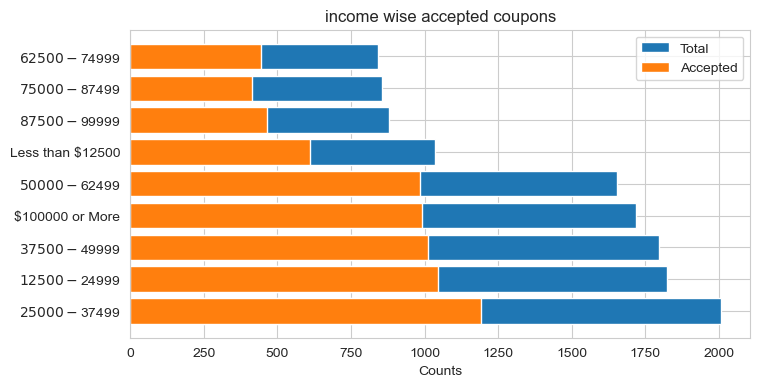

,income,Total_Count,Accepted,Rejected,%Accepted,%Rejected
2,$25000 - $37499,2006,1190,816,59.322,40.678
1,$12500 - $24999,1825,1047,778,57.370,42.630
3,$37500 - $49999,1795,1010,785,56.267,43.733
0,$100000 or More,1717,992,725,57.775,42.225
4,$50000 - $62499,1655,984,671,59.456,40.544
8,Less than $12500,1034,612,422,59.188,40.812
7,$87500 - $99999,879,465,414,52.901,47.099
6,$75000 - $87499,856,414,442,48.364,51.636
5,$62500 - $74999,843,443,400,52.550,47.450


In [30]:
univariate_analysis('income')

#### Observations:

  - Most users in this data have income in between 12500 to 49999
  - Users who have low income and high income accept more coupons than others.
  - Users who have medium-range income are mostly rejecting the coupon.

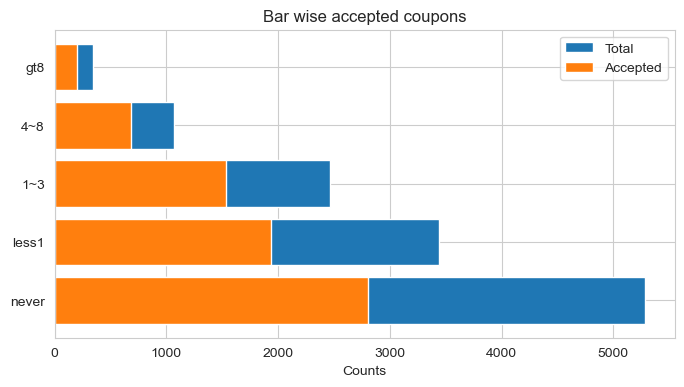

,Bar,Total_Count,Accepted,Rejected,%Accepted,%Rejected
4,never,5285,2806,2479,53.094,46.906
3,less1,3438,1936,1502,56.312,43.688
0,1~3,2468,1533,935,62.115,37.885
1,4~8,1071,681,390,63.585,36.415
2,gt8,348,201,147,57.759,42.241


In [31]:
univariate_analysis('Bar')

#### Observations:

  - Most users in this data never visit a Bar.
  - Very few users frequently (greater than 8 times) visit a Bar.
  - Users who visited Bar 1to3 times or 4to8 times have a higher coupon             acceptance ratio.

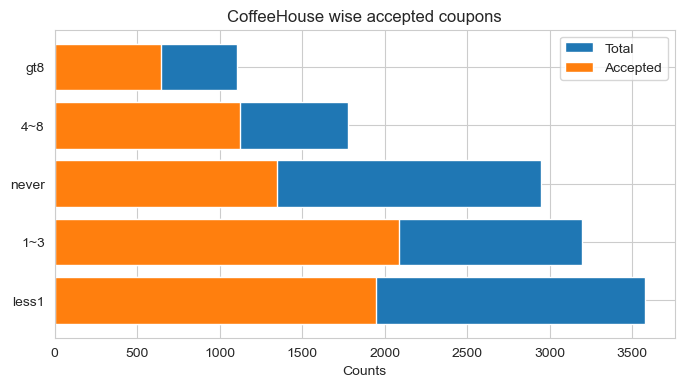

,CoffeeHouse,Total_Count,Accepted,Rejected,%Accepted,%Rejected
3,less1,3579,1949,1630,54.457,45.543
0,1~3,3199,2089,1110,65.302,34.698
4,never,2946,1348,1598,45.757,54.243
1,4~8,1779,1125,654,63.238,36.762
2,gt8,1107,646,461,58.356,41.644


In [32]:
univariate_analysis('CoffeeHouse')

#### Observations:

  - Most users in this data have at least 1 time visited Coffee House.
  - Users who visited Coffee House 1to3 times or 4to8 times have a higher           coupon acceptance ratio.

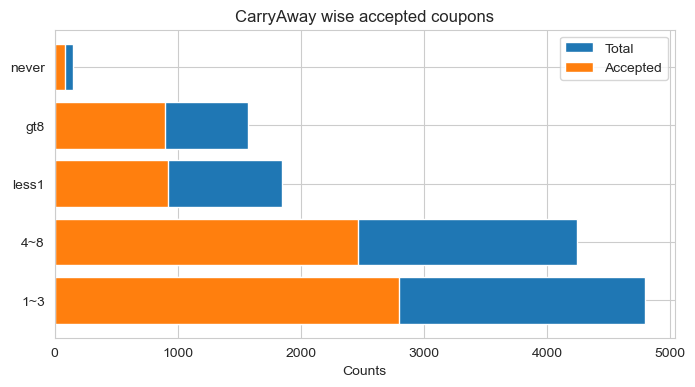

,CarryAway,Total_Count,Accepted,Rejected,%Accepted,%Rejected
0,1~3,4795,2793,2002,58.248,41.752
1,4~8,4242,2462,1780,58.039,41.961
3,less1,1849,921,928,49.811,50.189
2,gt8,1572,900,672,57.252,42.748
4,never,152,81,71,53.289,46.711


In [33]:
univariate_analysis('CarryAway')

#### Observations:

  - Most users in this data have visited 1 to 8 times Carry Away services.
  - Users who visited Carry Away services greater than 1 time have the highest     coupon acceptance ratio is approx 58%.

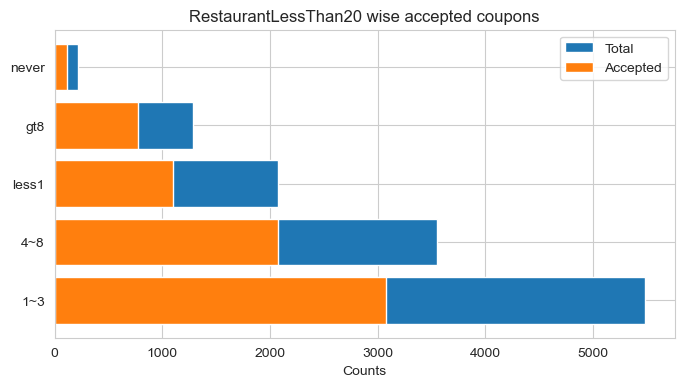

,RestaurantLessThan20,Total_Count,Accepted,Rejected,%Accepted,%Rejected
0,1~3,5485,3083,2402,56.208,43.792
1,4~8,3553,2075,1478,58.401,41.599
3,less1,2071,1103,968,53.259,46.741
2,gt8,1282,779,503,60.764,39.236
4,never,219,117,102,53.425,46.575


In [34]:
univariate_analysis('RestaurantLessThan20')

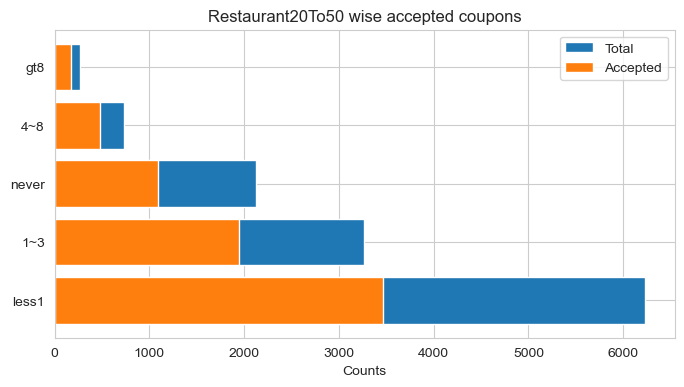

,Restaurant20To50,Total_Count,Accepted,Rejected,%Accepted,%Rejected
3,less1,6230,3468,2762,55.666,44.334
0,1~3,3266,1942,1324,59.461,40.539
4,never,2122,1095,1027,51.602,48.398
1,4~8,728,477,251,65.522,34.478
2,gt8,264,175,89,66.288,33.712


In [35]:
univariate_analysis('Restaurant20To50')

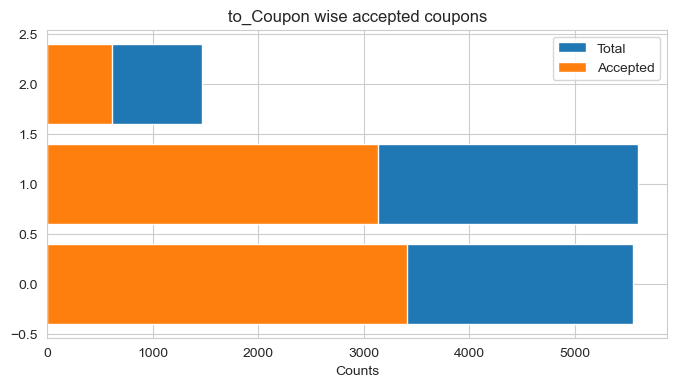

,to_Coupon,Total_Count,Accepted,Rejected,%Accepted,%Rejected
1,1,5596,3136,2460,56.040,43.960
0,0,5551,3407,2144,61.376,38.624
2,2,1463,614,849,41.969,58.031


In [36]:
univariate_analysis('to_Coupon')

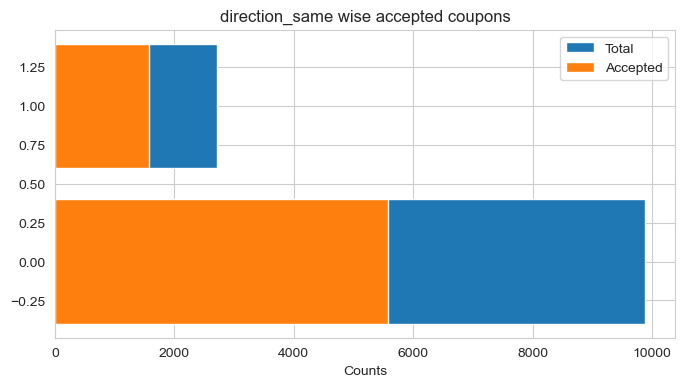

,direction_same,Total_Count,Accepted,Rejected,%Accepted,%Rejected
0,0,9892,5576,4316,56.369,43.631
1,1,2718,1581,1137,58.168,41.832


In [37]:
univariate_analysis('direction_same')

#### Observations:

  - Most coupons offered are in the same direction as the user's destination.
  - Same and Opposite both direction coupons have almost similar acceptance         ratios.

## Bivariate Analysis

In [38]:
def bivariate_analysis(col1,col2,c1,c2,no_row):
    a = list(data[col1].unique())
    b = list(data[col2].unique())
    df = pd.DataFrame([(i, j) for i in a for j in b], columns=[col1,col2])
    Total_Count=[]; Accepted=[]; Rejected=[]
    for i in range(df.shape[0]):
        Total_Count.append((data[(c1==df[col1][i]) & (c2==df[col2][i])]).shape[0])
        Accepted.append((data[(c1==df[col1][i]) & (c2==df[col2][i]) & (data.Y==1)]).shape[0])
        Rejected.append((data[(c1==df[col1][i]) & (c2==df[col2][i]) & (data.Y==0)]).shape[0])
    df['Total_Count'] = Total_Count
    df['Accepted'] = Accepted
    df['Rejected'] = Rejected
    df['%Accepted'] = round(df['Accepted']/df['Total_Count']*100,3)
    df['%Rejected'] = round(df['Rejected']/df['Total_Count']*100,3)
    df = df.dropna()
    df = df.sort_values(by='%Accepted', ascending=False)
    d = pd.concat([df.head(no_row), df.tail(no_row)], axis=0)
    return d

### What time do users go to Work, Home, or No Urgent Place, and with whom?

Text(0.5, 1.0, 'destination vs time (count)')

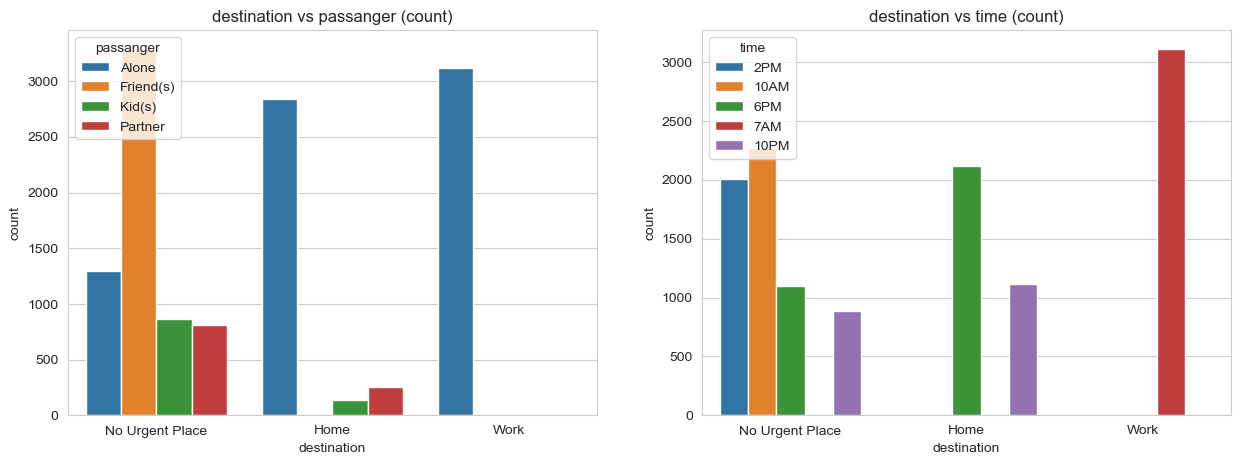

In [39]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['destination'],hue=data['passanger'],ax=axes[0])
sns.countplot(data['destination'],hue=data['time'],ax=axes[1])
axes[0].set_title('destination vs passanger (count)'); axes[1].set_title('destination vs time (count)')

In [40]:
bivariate_analysis('destination','time',data.destination,data.time,3)

,destination,time,Total_Count,Accepted,Rejected,%Accepted,%Rejected
2,No Urgent Place,6PM,1102,730,372,66.243,33.757
0,No Urgent Place,2PM,2006,1327,679,66.152,33.848
1,No Urgent Place,10AM,2271,1380,891,60.766,39.234
7,Home,6PM,2118,1151,967,54.344,45.656
13,Work,7AM,3114,1553,1561,49.872,50.128
9,Home,10PM,1112,484,628,43.525,56.475


In [41]:
bivariate_analysis('passanger','time',data.passanger,data.time,3)

,passanger,time,Total_Count,Accepted,Rejected,%Accepted,%Rejected
7,Friend(s),6PM,592,448,144,75.676,24.324
0,Alone,2PM,361,265,96,73.407,26.593
17,Partner,6PM,309,216,93,69.903,30.097
12,Kid(s),6PM,267,125,142,46.816,53.184
4,Alone,10PM,990,461,529,46.566,53.434
14,Kid(s),10PM,167,43,124,25.749,74.251


#### Observations:

  - At 7 AM, only working users are going out Alone.
  - For Home, Users mostly go alone only at 6 PM or 10 PM.
  - With Friends, Users only go to No Urgent Place.
  - At 2 PM, Users only go to No Urgent Place.
  - For No Urgent Place, Users mostly go Alone at 2 PM and with Friends at 6       PM.
  - Users who go with Friends at 6 PM have the highest acceptance ratio.
  - Users who go Alone at 2 PM also have the highest acceptance ratio.
  - Users who go with kids at 10 PM mostly reject the coupons.

In [42]:
bivariate_analysis('coupon','expiration',data.coupon,data.expiration,3)

,coupon,expiration,Total_Count,Accepted,Rejected,%Accepted,%Rejected
0,Restaurant(<20),1d,1351,1123,228,83.124,16.876
4,Carry out & Take away,1d,1411,1102,309,78.101,21.899
5,Carry out & Take away,2h,933,618,315,66.238,33.762
6,Bar,1d,1553,640,913,41.211,58.789
7,Bar,2h,457,184,273,40.263,59.737
9,Restaurant(20-50),2h,535,160,375,29.907,70.093


#### Observations:

  - Most Users prefer to accept one-day expiration coupons than two hours           expiration coupons.
  - Most Users accept the one-day expiration of Restaurant(<20) and Carry out &     Take away coupons.
  - At any time, Most Users accept the two hours expiration of Carry out & Take     away coupon.
  - Users mainly do not prefer to accept expensive Restaurant coupons with a       low expiration time (2h).
  - Bar coupons have the least second preference in coupon acceptance.

### At what time, which coupon acceptance ratio is high?

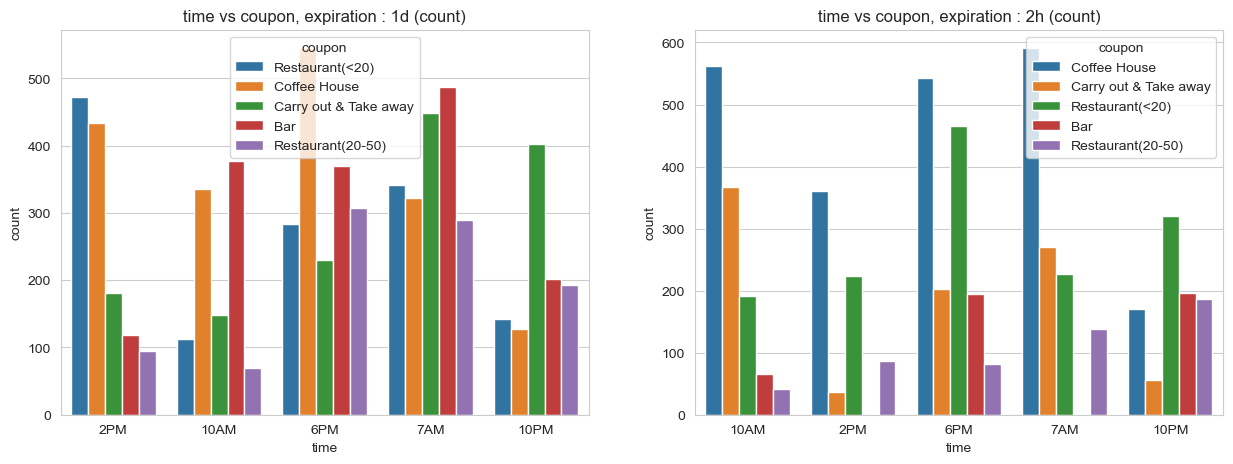

In [43]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data[data.expiration == '1d']['time'],hue=data[data.expiration == '1d']['coupon'],ax=axes[0])
sns.countplot(data[data.expiration == '2h']['time'],hue=data[data.expiration == '2h']['coupon'],ax=axes[1])
axes[0].set_title('time vs coupon, expiration : 1d (count)'); axes[1].set_title('time vs coupon, expiration : 2h (count)');

In [44]:
bivariate_analysis('coupon','time',data.coupon,data.time,4)

,coupon,time,Total_Count,Accepted,Rejected,%Accepted,%Rejected
10,Carry out & Take away,2PM,218,189,29,86.697,13.303
2,Restaurant(<20),6PM,748,619,129,82.754,17.246
12,Carry out & Take away,6PM,433,357,76,82.448,17.552
0,Restaurant(<20),2PM,696,567,129,81.466,18.534
18,Bar,7AM,487,178,309,36.550,63.450
16,Bar,10AM,443,160,283,36.117,63.883
15,Bar,2PM,118,40,78,33.898,66.102
24,Restaurant(20-50),10PM,380,125,255,32.895,67.105


#### Observations:

  - At 7 AM and 2 PM, the users will not get any request for a Bar coupon with     a 2h expiration.
  - From 7 AM to 6 PM, Coffee House coupon ask is maximum.
  - At 10 PM, only Carry out & Take away(1d) and Restaurant(<20)(2h) coupon ask     is highest.
  - At 2 PM and 6 PM, users mostly accept Restaurant(<20) and Carry out coupons     with acceptance ratios above 80%.
  - At 2 PM, Users mostly accept Carry out & Take away coupons with an             acceptance ratio approx 86%.
  - At 10 PM, generally, users do not accept expensive restaurant coupons.
  - Users mostly reject coupons for Bar at 7 AM, 10 AM, and 2 PM.

### Bivariate Analysis of Weather and Temperature

Text(0.5, 1.0, 'time vs weather (count)')

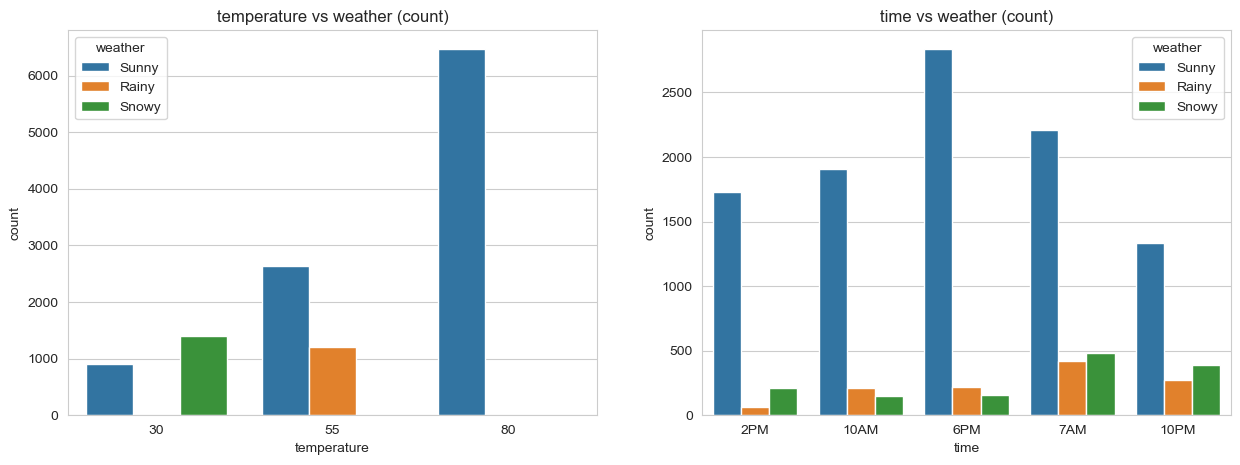

In [45]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['temperature'],hue=data['weather'],ax=axes[0])
sns.countplot(data['time'],hue=data['weather'],ax=axes[1])
axes[0].set_title('temperature vs weather (count)'); axes[1].set_title('time vs weather (count)')

#### Observations:

  - At Snowy weather, Temperature is always 30 F.
  - At Rainy weather, Temperature is always 55 F.
  - At 80 F Temperature, weather is always Sunny.
  - At any time, most Users prefer to go out when the weather is Sunny.

### Bivariate Analysis of weather and coupon type

In [46]:
bivariate_analysis('weather','coupon',data.weather,data.coupon,4)

,weather,coupon,Total_Count,Accepted,Rejected,%Accepted,%Rejected
0,Sunny,Restaurant(<20),2237,1718,519,76.799,23.201
2,Sunny,Carry out & Take away,1722,1312,410,76.190,23.810
12,Snowy,Carry out & Take away,305,215,90,70.492,29.508
7,Rainy,Carry out & Take away,317,193,124,60.883,39.117
9,Rainy,Restaurant(20-50),65,25,40,38.462,61.538
8,Rainy,Bar,427,155,272,36.300,63.700
13,Snowy,Bar,238,76,162,31.933,68.067
14,Snowy,Restaurant(20-50),177,54,123,30.508,69.492


#### Observations:

 - In Sunny weather, Restaurant(<20) and Carry out & Take away coupons have a      maximum acceptance ratio approx 76%.
 - In Snowy and Rainy weather, Carry out & Take away coupon has the highest        coupon acceptance ratio.
 - In Snowy and Rainy weather, Bar and expensive Restaurant has the lowest        coupon acceptance ratio.

### Analysis of passanger, maritalStatus and has_children features

Text(0.5, 1.0, 'age vs passanger (count)')

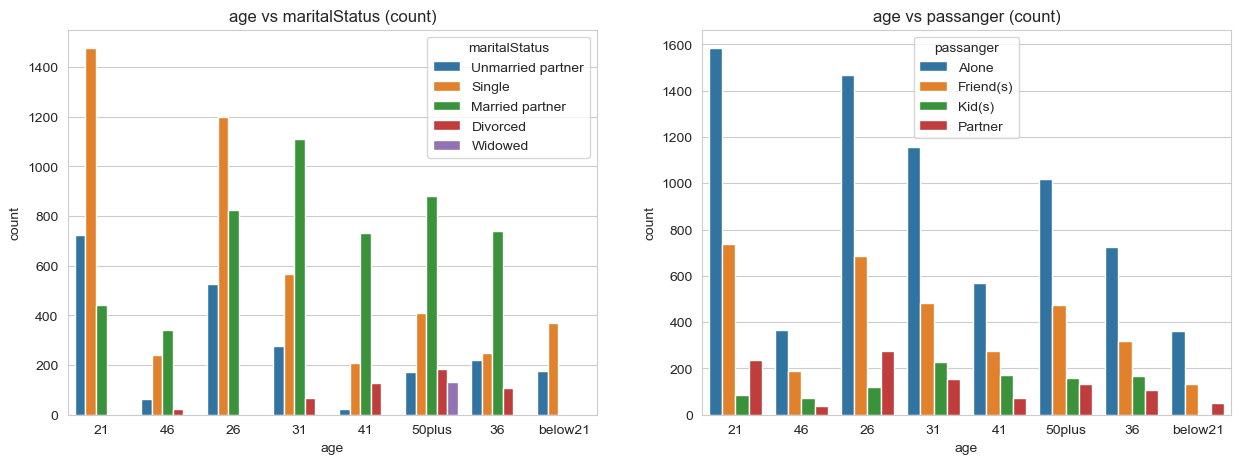

In [47]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['age'],hue=data['maritalStatus'],ax=axes[0])
sns.countplot(data['age'],hue=data['passanger'],ax=axes[1])
axes[0].set_title('age vs maritalStatus (count)'); axes[1].set_title('age vs passanger (count)')

#### Observations:

 - below21, 21, 26 age users most of single or have an unmarried partner.
 - 31, 36, 41, 46, 50plus age users most of have Married partner.
 - All Widowed users have 50plus age.
 - Maximum Divorced users have 50plus age.
 - All Divorced users have an age above 31.
 - below21 age users never travel with kid.
 - Most Single, Married and Unmarried Users go out Alone or with Friends.

### Which age group accept more coupon?

Text(0.5, 1.0, 'age vs coupon (Acceptance ratio)')

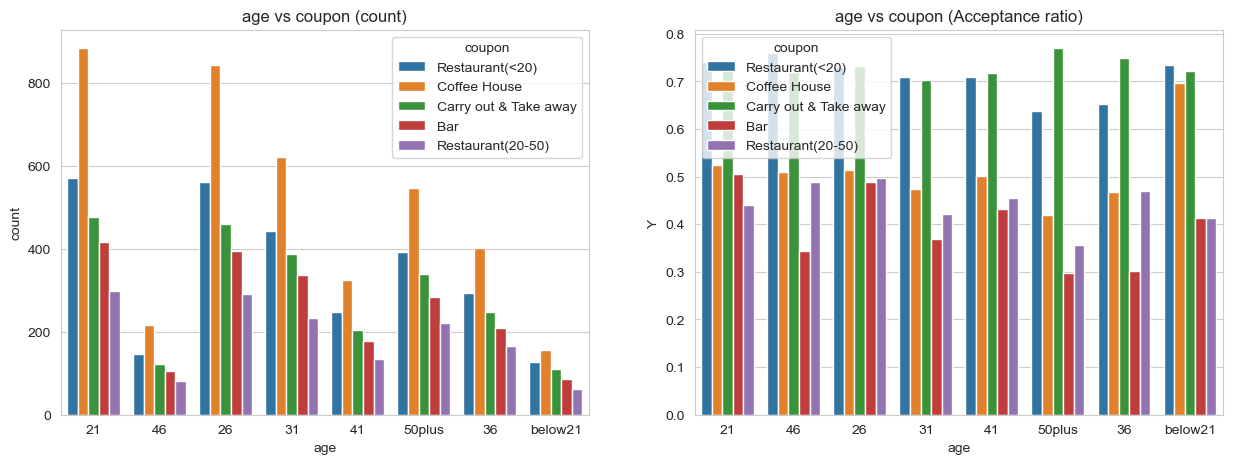

In [48]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['age'],hue=data['coupon'],ax=axes[0])
sns.barplot(ax=axes[1], x="age", y="Y", hue='coupon', ci=None, data=data)
axes[0].set_title('age vs coupon (count)'); axes[1].set_title('age vs coupon (Acceptance ratio)')

#### Observations:

 - For Bar coupons, 21 and 26 age users accept the coupon more than others.
 - Mostly every age users accept Carry out & Take away and Restaurant(<20)        coupons.
 - below21 age users have more acceptence for Coffee House coupons approx 70%.
 - Older age users have least acceptance for Bar Coupons.

### Bivariate Analysis of Bar and coupon type

,Bar,coupon,Total_Count,Accepted,Rejected,%Accepted,%Rejected
23,4~8,Bar,150,117,33,78.000,22.000
18,gt8,Bar,49,36,13,73.469,26.531
13,1~3,Bar,397,257,140,64.736,35.264
8,less1,Bar,563,250,313,44.405,55.595
3,never,Bar,851,164,687,19.271,80.729


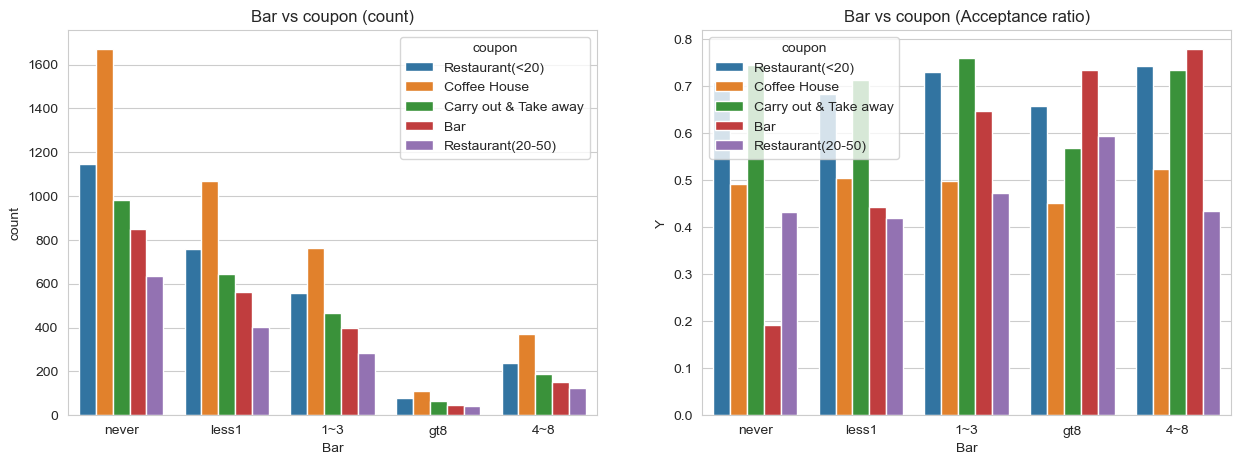

In [49]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['Bar'],hue=data['coupon'],ax=axes[0])
sns.barplot(ax=axes[1], x="Bar", y="Y", hue='coupon', ci=None, data=data)
axes[0].set_title('Bar vs coupon (count)'); axes[1].set_title('Bar vs coupon (Acceptance ratio)')
df = bivariate_analysis('Bar','coupon',data.Bar,data.coupon,13)
df[df.coupon == 'Bar']

#### Observations:

 - Users who have already been in Bar 4 to 8 time or more than 8 times has a      maximum acceptance ratio for Bar coupons.
 - Users who have never been to Bar have the least acceptance ratio for Bar        coupons.
 - Acceptance of Bar coupons depends on the Bar feature.

### Bivariate Analysis of CoffeeHouse and coupon type

,CoffeeHouse,coupon,Total_Count,Accepted,Rejected,%Accepted,%Rejected
11,4~8,Coffee House,538,369,169,68.587,31.413
21,gt8,Coffee House,342,225,117,65.789,34.211
16,1~3,Coffee House,1038,672,366,64.740,35.260
6,less1,Coffee House,1144,548,596,47.902,52.098
1,never,Coffee House,927,175,752,18.878,81.122


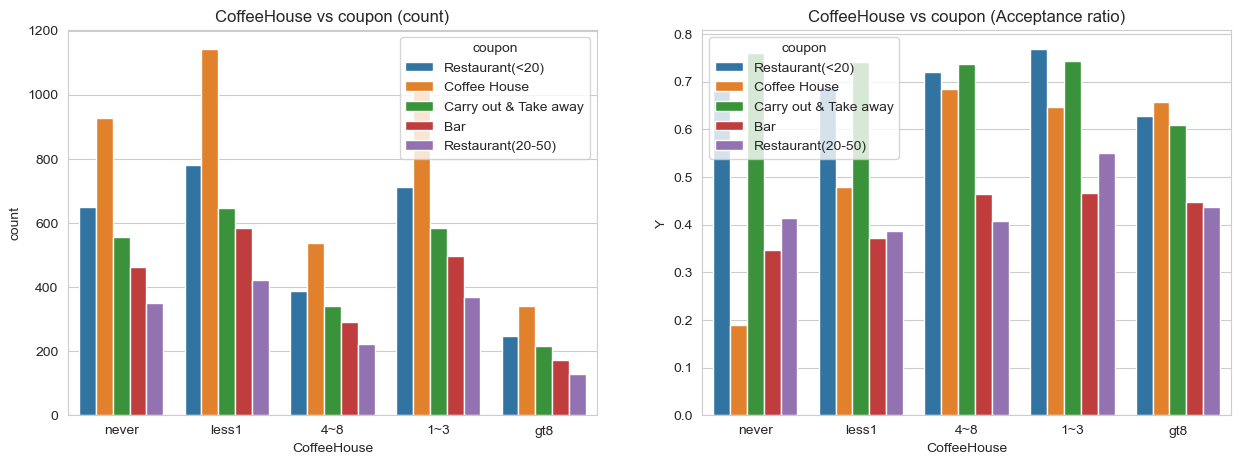

In [50]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['CoffeeHouse'],hue=data['coupon'],ax=axes[0])
sns.barplot(ax=axes[1], x="CoffeeHouse", y="Y", hue='coupon', ci=None, data=data)
axes[0].set_title('CoffeeHouse vs coupon (count)'); axes[1].set_title('CoffeeHouse vs coupon (Acceptance ratio)')
df = bivariate_analysis('CoffeeHouse','coupon',data.CoffeeHouse,data.coupon,13)
df[df.coupon == 'Coffee House']

#### Observations:

 - Users who have already been in Coffee House 4 to 8 time or more than 8 times    has a maximum acceptance ratio for Coffee House coupons.
 - Users who have never been to Coffee House have the least acceptance ratio      for Coffee House coupons.
 - Acceptance of Coffee House coupons depends on the CoffeeHouse feature.

### Bivariate Analysis of CarryAway and coupon type 

,CarryAway,coupon,Total_Count,Accepted,Rejected,%Accepted,%Rejected
7,4~8,Carry out & Take away,804,606,198,75.373,24.627
22,never,Carry out & Take away,31,23,8,74.194,25.806
2,1~3,Carry out & Take away,870,642,228,73.793,26.207
12,gt8,Carry out & Take away,293,215,78,73.379,26.621
17,less1,Carry out & Take away,346,234,112,67.630,32.370


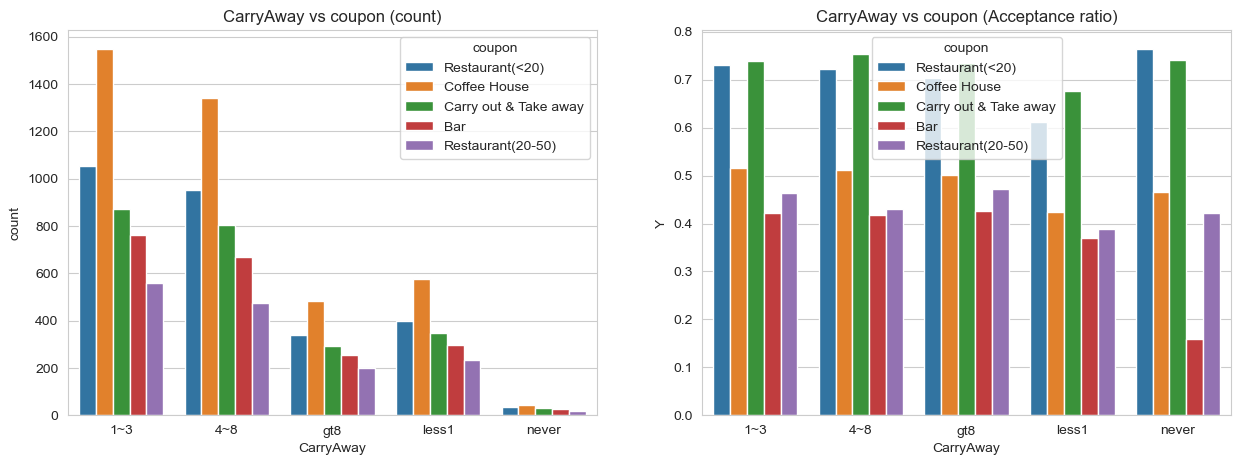

In [51]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['CarryAway'],hue=data['coupon'],ax=axes[0])
sns.barplot(ax=axes[1], x="CarryAway", y="Y", hue='coupon', ci=None, data=data)
axes[0].set_title('CarryAway vs coupon (count)'); axes[1].set_title('CarryAway vs coupon (Acceptance ratio)')
df = bivariate_analysis('CarryAway','coupon',data.CarryAway,data.coupon,13)
df[df.coupon == 'Carry out & Take away']

#### Observations:

 - Acceptance of Carry out & Take away coupons do not depend on the CarryAway      feature.
 - Users who have never been to Carry out & Take away have 2nd highest            acceptance ratio for Carry out coupons.
 - Every users have the good acceptance ratio for Carry out & Take away coupons

### Bivariate Analysis of RestaurantLessThan20 and coupon type 

,RestaurantLessThan20,coupon,Total_Count,Accepted,Rejected,%Accepted,%Rejected
15,gt8,Restaurant(<20),288,219,69,76.042,23.958
0,4~8,Restaurant(<20),795,572,223,71.950,28.050
5,1~3,Restaurant(<20),1184,837,347,70.693,29.307
10,less1,Restaurant(<20),458,309,149,67.467,32.533
20,never,Restaurant(<20),54,30,24,55.556,44.444


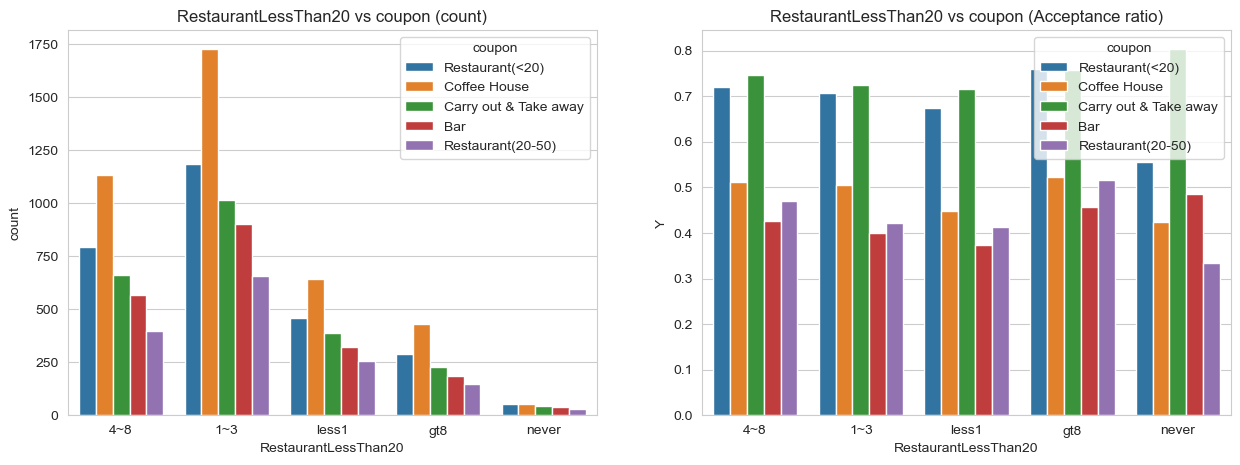

In [52]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['RestaurantLessThan20'],hue=data['coupon'],ax=axes[0])
sns.barplot(ax=axes[1], x="RestaurantLessThan20", y="Y", hue='coupon', ci=None, data=data)
axes[0].set_title('RestaurantLessThan20 vs coupon (count)'); axes[1].set_title('RestaurantLessThan20 vs coupon (Acceptance ratio)')
df = bivariate_analysis('RestaurantLessThan20','coupon',data.RestaurantLessThan20,data.coupon,13)
df[df.coupon == 'Restaurant(<20)']

### Bivariate Analysis of Restaurant20To50 and coupon type

,Restaurant20To50,coupon,Total_Count,Accepted,Rejected,%Accepted,%Rejected
19,gt8,Restaurant(20-50),32,22,10,68.750,31.250
24,4~8,Restaurant(20-50),91,57,34,62.637,37.363
4,1~3,Restaurant(20-50),381,201,180,52.756,47.244
9,less1,Restaurant(20-50),754,309,445,40.981,59.019
14,never,Restaurant(20-50),230,68,162,29.565,70.435


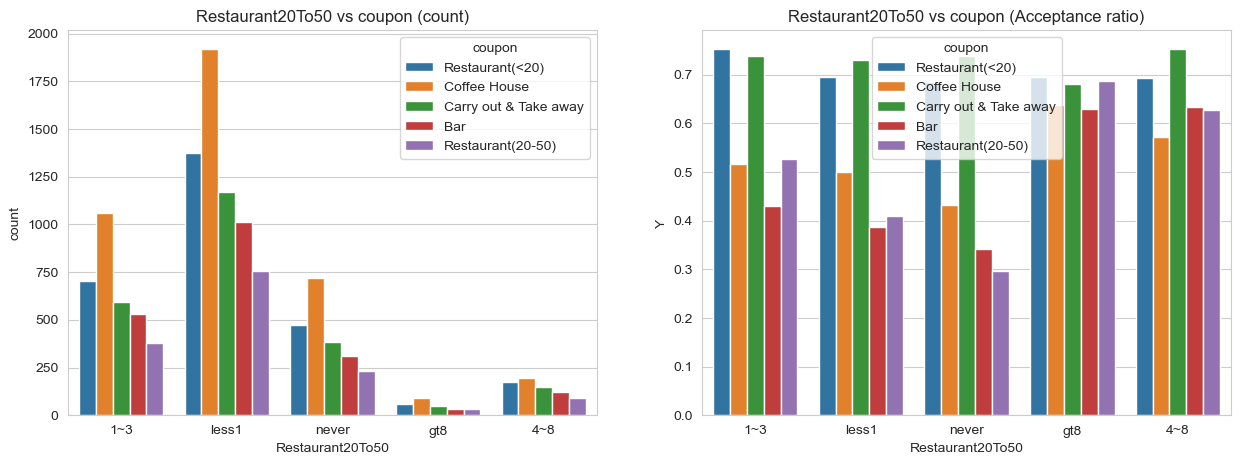

In [53]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['Restaurant20To50'],hue=data['coupon'],ax=axes[0])
sns.barplot(ax=axes[1], x="Restaurant20To50", y="Y", hue='coupon', ci=None, data=data)
axes[0].set_title('Restaurant20To50 vs coupon (count)'); axes[1].set_title('Restaurant20To50 vs coupon (Acceptance ratio)')
df = bivariate_analysis('Restaurant20To50','coupon',data.Restaurant20To50,data.coupon,13)
df[df.coupon == 'Restaurant(20-50)']

#### Observations:

 - Users who have already been in expensive Restaurant grater than 8 times have    the highest acceptance ratio for Restaurant(20-50) coupons.
 - Users who have never been to expensive Restaurant have the least acceptance    ratio for Restaurant(20-50) coupons.
 - Acceptance of Restaurant(20-50) coupons depends on the Restaurant20To50        feature.

### Bivariate Analysis of to_Coupon and coupon type

,to_Coupon,coupon,Total_Count,Accepted,Rejected,%Accepted,%Rejected
5,1,Restaurant(<20),934,708,226,75.803,24.197
0,0,Restaurant(<20),1538,1158,380,75.293,24.707
2,0,Carry out & Take away,872,656,216,75.229,24.771
7,1,Carry out & Take away,1250,904,346,72.320,27.680
8,1,Bar,823,329,494,39.976,60.024
13,2,Bar,510,197,313,38.627,61.373
11,2,Coffee House,310,107,203,34.516,65.484
10,2,Restaurant(<20),307,101,206,32.899,67.101


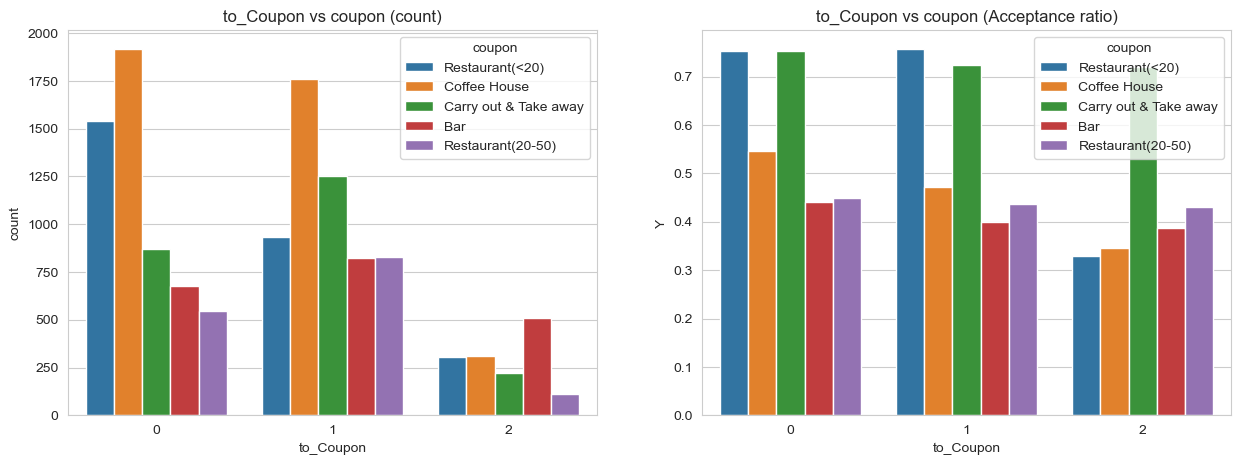

In [54]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['to_Coupon'],hue=data['coupon'],ax=axes[0])
sns.barplot(ax=axes[1], x="to_Coupon", y="Y", hue='coupon', ci=None, data=data)
axes[0].set_title('to_Coupon vs coupon (count)'); axes[1].set_title('to_Coupon vs coupon (Acceptance ratio)')
bivariate_analysis('to_Coupon','coupon',data.to_Coupon,data.coupon,4)

### Bivariate Analysis of direction_same and coupon type

#### Observations:

 1.Users who have already been in inexpensive Restaurant grater than 8 times      have a maximum acceptance ratio for Restaurant((<)20($)) coupons.
 2.Users who have never been to inexpensive Restaurant have also 50 acceptance    ratio for Restaurant((<)20($)) coupons.
 3.Acceptance of Restaurant((<)20($)) coupons depends on the                      RestaurantLessThan20 feature.
 4.Every users have the good acceptance ratio for Restaurant(<20$) coupons

Text(0.5, 1.0, 'direction_same vs coupon (Acceptance ratio)')

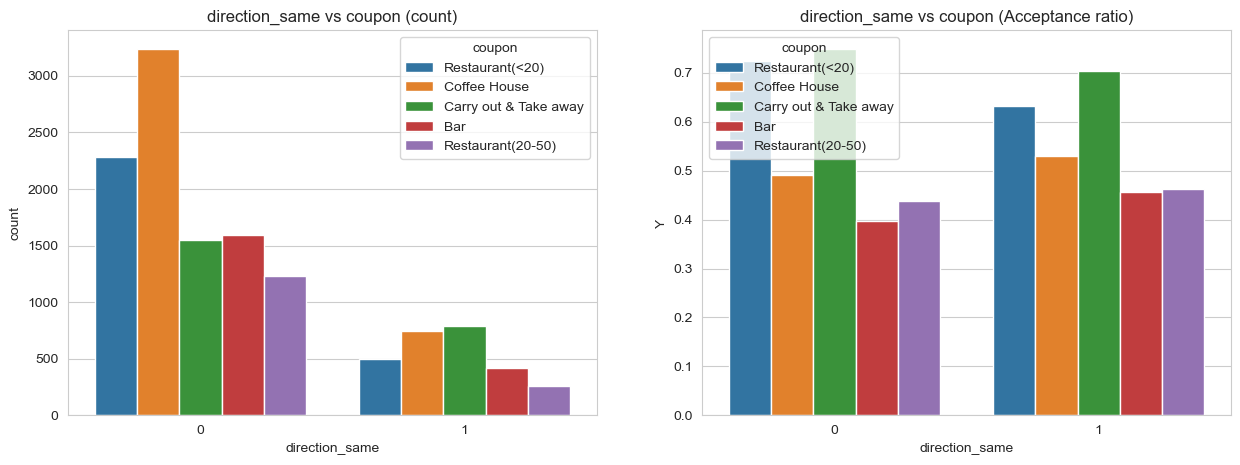

In [55]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['direction_same'],hue=data['coupon'],ax=axes[0])
sns.barplot(ax=axes[1], x="direction_same", y="Y", hue='coupon', ci=None, data=data)
axes[0].set_title('direction_same vs coupon (count)'); axes[1].set_title('direction_same vs coupon (Acceptance ratio)')

#### Observations:

 - 0: direction_same, 1: direction_opposite
 - Very few opposite-direction coupons are offered to users.
 - Same and Opposite direction coupons have almost similar acceptance ratios      for every coupon type.

## Performance Metric

  In this Problem, Task is Binary Class Classification.

  Business constraints are:

   - Interpretability is most important
   - The probability of a datapoint belonging to each class is needed
   - Low latency requirement
   - Less number of misclassification points
   - The condition based model performs best